# TACO (Garbage) Detection (SSD MobileNet v2) with TensorFlow

TACO can be found here: http://tacodataset.org/. 🌮 is an open image dataset of waste in the wild. It contains photos of litter taken under diverse environments, from tropical beaches to London streets.

We are going to use pretrained models in this notebook to show how you can do inference on them of unseen images. The pretrained models can be found here: https://www.kaggle.com/bouweceunen/trained-models-taco-trash-annotations-in-context

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import os

In [22]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 98743, done.
remote: Counting objects: 100% (1250/1250), done.
remote: Compressing objects: 100% (630/630), done.
remote: Total 98743 (delta 685), reused 1054 (delta 592), pack-reused 97493 (from 1)
Receiving objects: 100% (98743/98743), 622.28 MiB | 22.83 MiB/s, done.
Resolving deltas: 100% (71678/71678), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [23]:
# install object_detection library
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .


Usage:   
  /usr/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/bin/python3 -m pip install [options] <archive url/path> ...

option --use-feature: invalid choice: '2020-resolver' (choose from 'fast-deps', 'truststore', 'no-binary-enable-wheel-cache')


In [24]:
!pip install tensorflow-object-detection-api

In [25]:
!pip install protobuf==3.20.3

In [26]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [27]:
!pip install --upgrade tensorflow-object-detection-api

In [28]:
!pip install pipdeptree
!pipdeptree

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
│   │           │   │   │   └── traitlets [required: Any, installed: 5.7.1]
│   │           │   │   ├── jupyter_core [required: >=4.12,!=5.0.*, installed: 5.7.2]
│   │           │   │   │   ├── platformdirs [required: >=2.5, installed: 4.3.6]
│   │           │   │   │   └── traitlets [required: >=5.3, installed: 5.7.1]
│   │           │   │   ├── matplotlib-inline [required: >=0.1, installed: 0.1.7]
│   │           │   │   │   └── traitlets [required: Any, installed: 5.7.1]
│   │           │   │   ├── nest-asyncio [required: Any, installed: 1.6.0]
│   │           │   │   ├── packaging [required: Any, installed: 24.2]
│   │           │   │   ├── psutil [required: Any, installed: 5.9.5]
│   │           │   │   ├── pyzmq [required: >=24, installed: 24.0.1]
│   │           │   │   ├── tornado [required: >=6.1, installed: 6.3.3]
│   │           │   │   └── traitlets [required: >=5.4.0, installed: 5.7.1]
│   │     

In [29]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

In [30]:
# reconstruct frozen graph
def reconstruct(pb_path):
    if not os.path.isfile(pb_path):
        print("Error: %s not found" % pb_path)

    print("Reconstructing Tensorflow model")
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(pb_path, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    print("Success!")
    return detection_graph

In [31]:
# visualize detection
def image2np(image):
    (w, h) = image.size
    return np.array(image.getdata()).reshape((h, w, 3)).astype(np.uint8)

def image2tensor(image):
    npim = image2np(image)
    return np.expand_dims(npim, axis=0)

%matplotlib inline
def detect(detection_graph, test_image_path):
    with detection_graph.as_default():
        gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.01)
        with tf.compat.v1.Session(graph=detection_graph,config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(test_image_path)
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image2tensor(image)}
            )

            npim = image2np(image)
            vis_util.visualize_boxes_and_labels_on_image_array(
                npim,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=15)
            plt.figure(figsize=(12, 8))
            plt.imshow(npim)
            plt.show()

# Create LabelMap

First we need to create the label map.

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
DATA_DIR = '/content/drive/My Drive/garbage/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, '/content/drive/My Drive/garbage/data/annotations.json')
NCLASSES = 60

In [34]:
with open(ANNOTATIONS_FILE) as json_file:
    data = json.load(json_file)

categories = data['categories']

In [35]:
print('Building label map from examples')

labelmap = string_int_label_map_pb2.StringIntLabelMap()
for idx,category in enumerate(categories):
    item = labelmap.item.add()
    # label map id 0 is reserved for the background label
    item.id = int(category['id'])+1
    item.name = category['name']

with open('/content/drive/My Drive/garbage/labelmap.pbtxt', 'w') as f:
    f.write(text_format.MessageToString(labelmap))

print('Label map witten to labelmap.pbtxt')

with open('/content/drive/My Drive/garbage/labelmap.pbtxt') as f:
    pprint.pprint(f.readlines())

Building label map from examples
Label map witten to labelmap.pbtxt
['item {\n',
 '  name: "Aluminium foil"\n',
 '  id: 1\n',
 '}\n',
 'item {\n',
 '  name: "Battery"\n',
 '  id: 2\n',
 '}\n',
 'item {\n',
 '  name: "Aluminium blister pack"\n',
 '  id: 3\n',
 '}\n',
 'item {\n',
 '  name: "Carded blister pack"\n',
 '  id: 4\n',
 '}\n',
 'item {\n',
 '  name: "Other plastic bottle"\n',
 '  id: 5\n',
 '}\n',
 'item {\n',
 '  name: "Clear plastic bottle"\n',
 '  id: 6\n',
 '}\n',
 'item {\n',
 '  name: "Glass bottle"\n',
 '  id: 7\n',
 '}\n',
 'item {\n',
 '  name: "Plastic bottle cap"\n',
 '  id: 8\n',
 '}\n',
 'item {\n',
 '  name: "Metal bottle cap"\n',
 '  id: 9\n',
 '}\n',
 'item {\n',
 '  name: "Broken glass"\n',
 '  id: 10\n',
 '}\n',
 'item {\n',
 '  name: "Food Can"\n',
 '  id: 11\n',
 '}\n',
 'item {\n',
 '  name: "Aerosol"\n',
 '  id: 12\n',
 '}\n',
 'item {\n',
 '  name: "Drink can"\n',
 '  id: 13\n',
 '}\n',
 'item {\n',
 '  name: "Toilet tube"\n',
 '  id: 14\n',
 '}\n',
 'it

In [36]:
!pip install --upgrade tensorflow-object-detection-api

In [37]:
! pip install tensorflow

In [38]:
from object_detection.utils import label_map_util
import tensorflow as tf

# Path to your labelmap.pbtxt
label_map_path = '/content/drive/My Drive/garbage/labelmap.pbtxt'

def validate_labelmap(path):
    with tf.io.gfile.GFile(path, 'r') as fid:
        label_map_string = fid.read()
        try:
            label_map = label_map_util.string_int_label_map_pb2.StringIntLabelMap()
            label_map.ParseFromString(label_map_string.encode('utf-8'))
            print("Label map parsed successfully!")
        except Exception as e:
            print(f"Error parsing label map: {e}")

validate_labelmap(label_map_path)

Error parsing label map: Error parsing message with type 'object_detection.protos.StringIntLabelMap'


In [39]:
def load_labelmap(path):
    """Load a label map in TensorFlow 2.x."""
    with tf.io.gfile.GFile(path, 'r') as fid:
        label_map_string = fid.read()
        label_map = string_int_label_map_pb2.StringIntLabelMap()
        label_map.ParseFromString(label_map_string.encode('utf-8'))
        return label_map

In [44]:
from object_detection.utils import label_map_util
import tensorflow as tf

# Custom wrapper for TensorFlow 2.x compatibility
def load_labelmap_tf2(path):
    """Load a label map in TensorFlow 2.x."""
    with tf.io.gfile.GFile(path, 'r') as fid:
        label_map_string = fid.read()
        label_map = label_map_util.string_int_label_map_pb2.StringIntLabelMap()
        label_map.ParseFromString(label_map_string.encode('utf-8'))
        return label_map

# Load label map
label_map = load_labelmap_tf2('/content/drive/My Drive/garbage/labelmap.pbtxt')
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NCLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

/tmp/ipykernel_60187/4292832823.py:10: RuntimeWarning: Unexpected end-group tag: Not all data was converted
  label_map.ParseFromString(label_map_string.encode('utf-8'))


# Reconstruct Frozen Graph

Now we are going to reconstruct the TensorFlow frozen graph (.pb).

In [45]:
detection_graph = reconstruct("/content/drive/My Drive/garbage/others/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


# Validate Test Images

We can now test it on some test images.

In [46]:
import PIL
print(PIL.__version__)

7.1.2


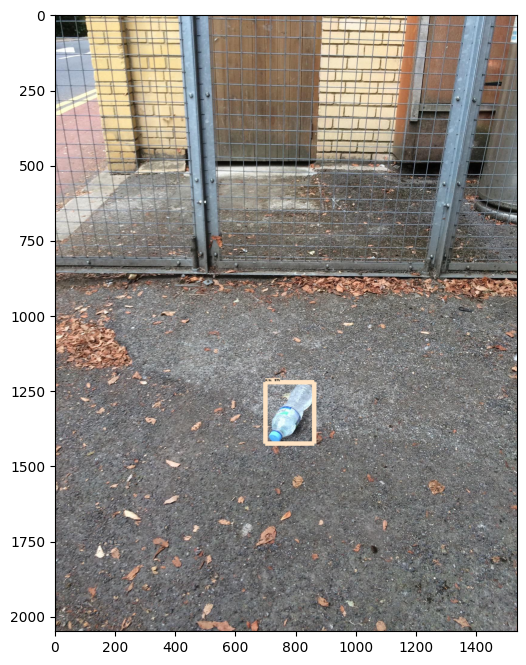

In [47]:
detect(detection_graph, '/content/drive/My Drive/garbage/data/batch_1/000000.jpg')

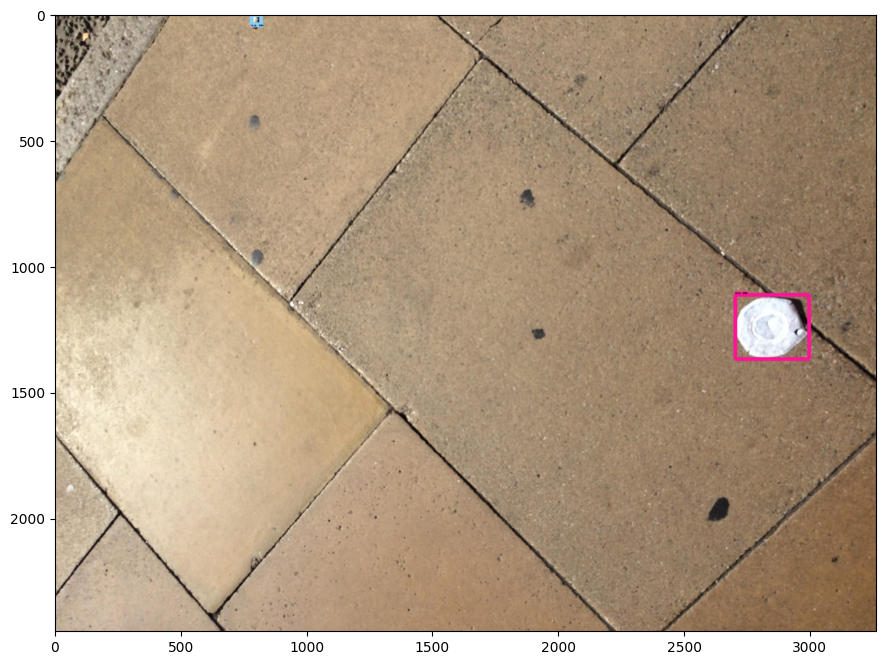

In [48]:
detect(detection_graph, '/content/drive/My Drive/garbage/data/batch_3/IMG_4852.JPG')

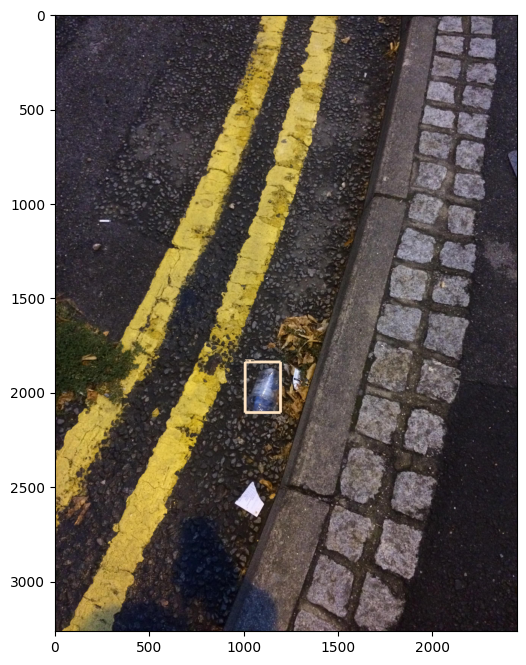

In [49]:
detect(detection_graph, '/content/drive/My Drive/garbage/data/batch_5/000000.JPG')

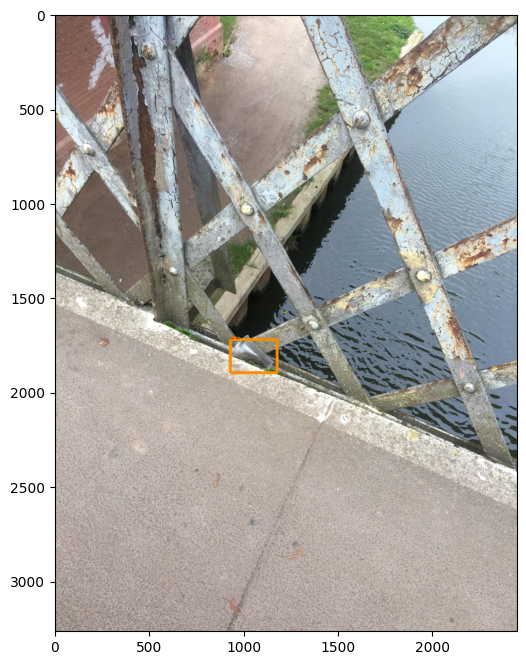

In [50]:
detect(detection_graph, '/content/drive/My Drive/garbage/data/batch_6/000000.JPG')

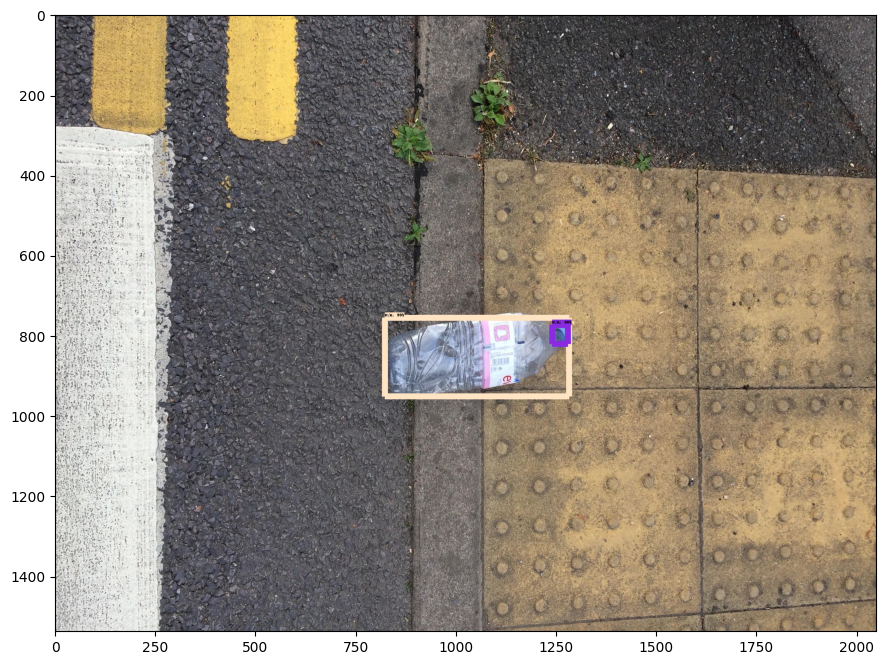

In [51]:
detect(detection_graph, '/content/drive/My Drive/garbage/data/batch_1/000001.jpg')

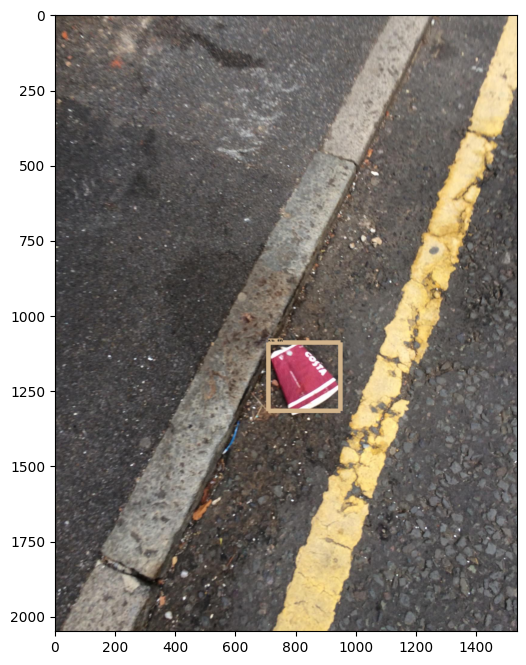

In [52]:
detect(detection_graph, '/content/drive/My Drive/garbage/data/batch_1/000003.jpg')

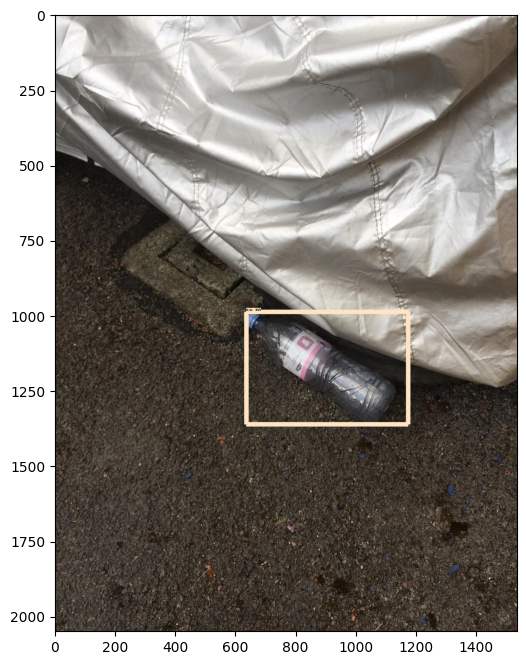

In [53]:
detect(detection_graph, '/content/drive/My Drive/garbage/data/batch_1/000010.jpg')

In [58]:
import tensorflow as tf

# Path to the .pb file
pb_model_path = '/content/drive/MyDrive/Waste_Detection_Model/ssd_mobilenet_v2_taco_2018_03_29.pb'

# Load the frozen graph
def load_frozen_model(model_path):
    with tf.io.gfile.GFile(model_path, "rb") as f:
        graph_def = tf.compat.v1.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.compat.v1.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
    return graph

graph = load_frozen_model(pb_model_path)
print("Model loaded successfully!")

Model loaded successfully!
